# Google Play Store Dataset – Data Overview & Quality Analysis

## Statistical Tests, Time EDA & Feature Engineering

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [70]:
df = pd.read_csv("C:\\Users\\anura\\Downloads\\googleplaystore_cleaned_interim.xls")
df.shape

(9638, 17)

In [71]:
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9638 entries, 0 to 9637
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   App             9638 non-null   object        
 1   Category        9638 non-null   object        
 2   Rating          9638 non-null   float64       
 3   Reviews         9638 non-null   float64       
 4   Size            8412 non-null   object        
 5   Installs        9638 non-null   float64       
 6   Type            9638 non-null   object        
 7   Price           9638 non-null   float64       
 8   Content Rating  9638 non-null   object        
 9   Genres          9638 non-null   object        
 10  Last Updated    9638 non-null   datetime64[ns]
 11  Current Ver     9630 non-null   object        
 12  Android Ver     9636 non-null   object        
 13  Size_MB         8412 non-null   float64       
 14  Log_Reviews     9638 non-null   float64       
 15  Log_

### Hypothesi Testing

##### T-Test: Free vs Paid App Ratings
* H0: Mean rating of Free apps = Mean rating of Paid apps
* H1: Mean rating of Free apps ≠ Mean rating of Paid apps

In [73]:
free_ratings = df[df['Type'] == 'Free']['Rating']
paid_ratings = df[df['Type'] == 'Paid']['Rating']

t_stat, p_value = stats.ttest_ind(free_ratings, paid_ratings, nan_policy='omit')

t_stat, p_value

(np.float64(-4.466108048479074), np.float64(8.056247235816813e-06))

###### Interpretation

* If p-value < 0.05, reject H0

* Indicates statistically significant difference in ratings

##### ANOVA: Rating Across Categories
* H0: Average ratings are equal across all categories
* H1: At least one category differs.

In [74]:
category_groups = [
df[df['Category'] == cat]['Rating']
for cat in df['Category'].unique()
]

f_stat, p_value = stats.f_oneway(*category_groups)

f_stat, p_value

(np.float64(6.552412301445963), np.float64(1.2211316485815526e-27))

###### Interpretation
* p-value < 0.05 → category impacts ratings. (reject H0)

##### Chi-Square Test: Category vs Type
* H0: Category and App Type are independent
* H1: They are dependent

In [75]:
contingency = pd.crosstab(df['Category'], df['Type'])

chi2, p, dof, expected = stats.chi2_contingency(contingency)

chi2, p

(np.float64(345.7466580185497), np.float64(2.5742394557040227e-54))

###### Interpretation
* Significant p-value indicates relationship between category and pricing type

### Time-Based Exploratory Data Analysis

#### Extract Date Features

In [76]:
df['Update_Year'] = df['Last Updated'].dt.year
df['Update_Month'] = df['Last Updated'].dt.month 
df['Update_Day'] = df['Last Updated'].dt.day 

#### Trend: App Updates Over Time

##### To analyze how app update activity has changed over time and understand marketgrowth and developer behavior across years. The line chart shows the number of app updates recorded each year. The x-axis represents the year, while the y-axis shows the total number of updates.

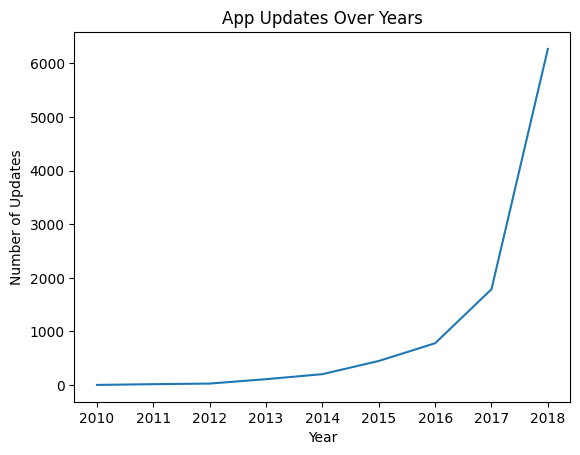

In [77]:
updates_by_year = df.groupby('Update_Year').size()

plt.figure()
updates_by_year.plot()
plt.title('App Updates Over Years')
plt.ylabel('Number of Updates')
plt.xlabel('Year')
plt.show()

**Key Insights:**
- App updates show a steady increase from 2010 to 2014.
- A sharp acceleration is observed after 2015.
- The highest number of updates occurs in 2018, indicating rapid platform growth.

### Feature Engineering

##### 1. Is Paid App

In [78]:
df['Is_Paid'] = np.where(df['Type'] == 'Paid', 1, 0)

**Purpose:**
- Converts a categorical feature (Free / Paid) into a binary numeric feature.

- Required for machine learning models, which cannot work directly with strings.

##### 2. Log Installs

In [79]:
df['Log_Installs'] = np.log1p(df['Installs']) 

**Purpose:**
- Reduces extreme skewness in install counts.

- Compresses large values while preserving relative differences.

##### 3. Review to Install Ratio

In [80]:
df['Review_Install_Ratio'] = df['Reviews'] / (df['Installs'] + 1)

**Purpose:**
- Measures user engagement per install.
- Normalizes reviews by install count.

##### 4. App Age (Years)

In [81]:
current_year = pd.Timestamp.now().year
df['App_Age_Years'] = current_year - df['Update_Year']

**purpose:**
- Captures temporal maturity of the app.
- Converts time into a numeric feature. 

##### 5. High Rated App Flag

In [82]:
df['High_Rated'] = np.where(df['Rating'] >= 4.5, 1, 0)

**purpose:**
- Converts a continuous metric into a decision-based feature
- Creates a clear success indicator.

In [83]:
df.shape

(9638, 24)

In [84]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,...,Log_Reviews,Log_Installs,Reviews_z,Update_Year,Update_Month,Update_Day,Is_Paid,Review_Install_Ratio,App_Age_Years,High_Rated
0,facebook,social,4.1,78158306.0,NaN,1.000000e+09,Free,0.0,teen,social,...,18.174247,20.723266,42.528864,2018,8,3,0,0.078158,7,0
1,whatsapp messenger,communication,4.4,69119316.0,NaN,1.000000e+09,Free,0.0,everyone,communication,...,18.051345,20.723266,37.596732,2018,8,3,0,0.069119,7,0
2,instagram,social,4.5,66577446.0,NaN,1.000000e+09,Free,0.0,teen,social,...,18.013876,20.723266,36.209758,2018,7,31,0,0.066577,7,1
3,messenger – text and video chat for free,communication,4.0,56646578.0,NaN,1.000000e+09,Free,0.0,everyone,communication,...,17.852342,20.723266,30.790973,2018,8,1,0,0.056647,7,0
4,clash of clans,game,4.6,44893888.0,98m,1.000000e+08,Free,0.0,everyone 10+,strategy,...,17.619812,18.420681,24.378108,2018,7,15,0,0.448939,7,1


In [85]:
df.to_csv('final_cleaned_day4.csv', index=False)